In [17]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# PyTorch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Numpy
np.random.seed(seed)

In [19]:
label_encoder = LabelEncoder()

In [20]:
def split_data_leave_one_out(df_label, subject_col, n_splits=5):
    """
       Splits the input DataFrame into training and test sets using Group K-Fold cross-validator.

       Args:
           df_label (pd.DataFrame): The input DataFrame with labels.
           subject_col (str): The column name containing the subject identifiers.
           n_splits (int, optional): The number of splits for the cross-validation. Defaults to 5.

       Returns:
           iterator: An iterator over the indices of the training and test sets.
       """

    groups = df_label[subject_col]  # normal is the id of subject.
    gkf = GroupKFold(n_splits=n_splits)
    gkf.get_n_splits(df_label, groups=groups)
    cv = gkf.split(df_label, groups=groups)
    return cv

In [21]:
df = pd.read_csv('/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt',sep=",", names=['id','target','timestamp','sensor_0','sensor_1','sensor_2'])
df.drop(columns=['timestamp'], inplace=True)

df = df[1:]

y = label_encoder.fit_transform(df['target'])
X = df.drop(columns=['target'])
X.dropna(axis=0, how='any', inplace=True)

print(X['id'].dtype)
print(X['id'].head())

X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
X['id'] = X['id'].astype(int)

<ipython-input-21-0bf67c6e35b2>:1: DtypeWarning: Columns (0,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt',sep=",", names=['id','target','timestamp','sensor_0','sensor_1','sensor_2'])


object
1    33
2    33
3    33
4    33
5    33
Name: id, dtype: object


In [32]:
def to_tensor(v, step,v_type=torch.float32):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  num_rows = v.shape[0]
  num_features = v.shape[1]

  v_num_new_rows = num_rows - num_rows % step
  v = v[:v_num_new_rows]

  v = torch.tensor(v.values, dtype=v_type).view(-1, step, num_features).to(device)
  print(v_num_new_rows)
  print(f"v.shape[0] is: {v.shape[0]}")
  return v,v_num_new_rows

In [25]:
def y_mode_select(y_tensor,step,y_type=torch.int64):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  y_tensor = torch.tensor(y_tensor,dtype=y_type).view(-1,step,1)
  y_tensor = mode(y_tensor,axis=1)[0].squeeze()
  return torch.tensor(y_tensor,dtype=y_type).to('cuda')

In [26]:
def train_y_test_y_to_tensor(y_train,y_test,y_train_index, y_test_index,step,y_type=torch.int64):
  y_train = y_train[:y_train_index]
  y_test = y_test[:y_test_index]
  return y_mode_select(y_train,step,y_type),y_mode_select(y_test,step,y_type)

def train_X_test_X_to_tensor(X_train, X_test, step):
  tensor_X_train, new_rows_train = to_tensor(X_train, step)
  tensor_X_test, new_rows_test = to_tensor(X_test, step)
  return tensor_X_train, new_rows_train, tensor_X_test, new_rows_test

In [59]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, 5)  # 输入通道3，输出通道32，卷积核大小5
        self.conv2 = nn.Conv1d(32, 64, 5)
        self.bn1 = nn.BatchNorm1d(32)  # 批标准化
        self.bn2 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(64 * 26, 256)  # 更多的全连接层神经元
        self.fc2 = nn.Linear(256, 6)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool1d(x, 2)
        # print(f"the shape is now :{x.shape}")
        x = nn.functional.dropout(x, 0.5)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

cnn_model = SimpleCNN().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01)

In [60]:
cv = split_data_leave_one_out(X,'id',n_splits=6)
f1_scores = []
loss_groups = []
for train_index, test_index in cv:
  print(train_index)
  print(test_index)
  X_train = X.loc[X.index.isin(train_index), :]
  X_test = X.loc[X.index.isin(test_index), :]
  X_train = X_train.drop(columns=['id'])
  X_test = X_test.drop(columns=['id'])

  X_train,X_train_new_rows,X_test,X_test_new_rows = train_X_test_X_to_tensor(X_train,X_test,60)
  y_train, y_test = y[train_index],y[test_index]
  y_train,y_test = train_y_test_y_to_tensor(y_train,y_test,X_train_new_rows, X_test_new_rows,60)
  X_train = X_train.permute(0,2,1)
  X_test = X_test.permute(0,2,1)

  current_loss_group = []
  for epoch in range(100):
      optimizer.zero_grad()
      output = cnn_model(X_train)
      loss = criterion(output, y_train)
      loss.backward()
      optimizer.step()
      current_loss_group.append(loss.item())

      if epoch % 10 == 0:
          print(f'Epoch [{epoch+1}/100], Loss: {loss.item()}')
  loss_groups.append(current_loss_group)
  with torch.no_grad():
        output = cnn_model(X_test)
        _, predicted = torch.max(output, 1)
        predicted = predicted.cpu().numpy()
        y_test = y_test.cpu().numpy()

        f1 = f1_score(y_test, predicted, average='weighted')
        f1_scores.append(f1)

[      0       1       2 ... 1098205 1098206 1098207]
[ 14353  14354  14355 ... 941961 941962 941963]
913080
v.shape[0] is: 15218
185040
v.shape[0] is: 3084
Epoch [1/100], Loss: 1.7011789083480835
Epoch [11/100], Loss: 1.2854782342910767
Epoch [21/100], Loss: 1.2031344175338745
Epoch [31/100], Loss: 1.1397422552108765
Epoch [41/100], Loss: 1.0861282348632812
Epoch [51/100], Loss: 1.0356425046920776
Epoch [61/100], Loss: 0.9904424548149109
Epoch [71/100], Loss: 0.9470676183700562
Epoch [81/100], Loss: 0.9075133800506592
Epoch [91/100], Loss: 0.8710771203041077
[      0       1       2 ... 1052822 1052823 1052824]
[ 225064  225065  225066 ... 1098205 1098206 1098207]
920400
v.shape[0] is: 15340
177720
v.shape[0] is: 2962
Epoch [1/100], Loss: 0.8671057820320129
Epoch [11/100], Loss: 0.8303936719894409
Epoch [21/100], Loss: 0.8039785027503967
Epoch [31/100], Loss: 0.775951623916626
Epoch [41/100], Loss: 0.7515855431556702
Epoch [51/100], Loss: 0.7345842123031616
Epoch [61/100], Loss: 0.715

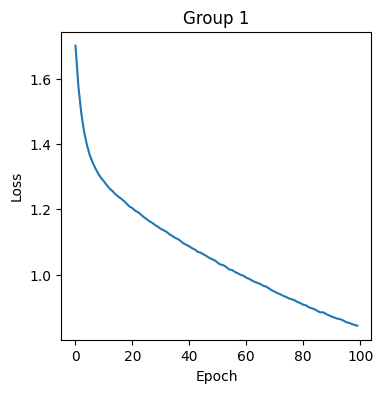

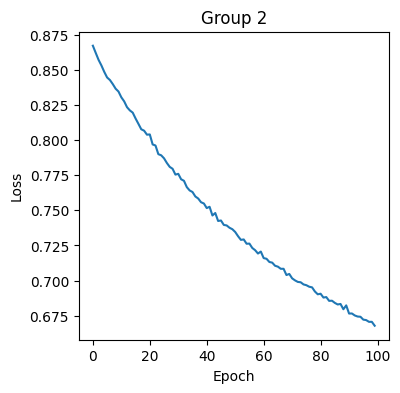

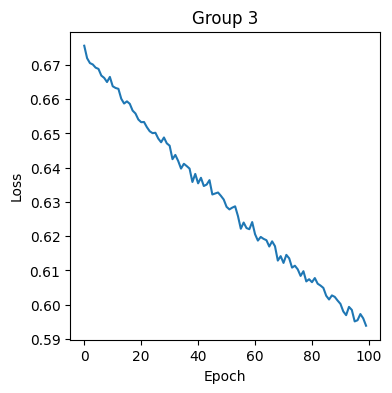

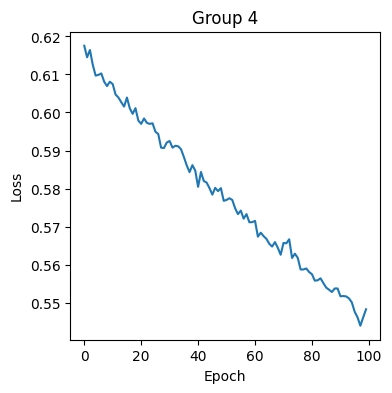

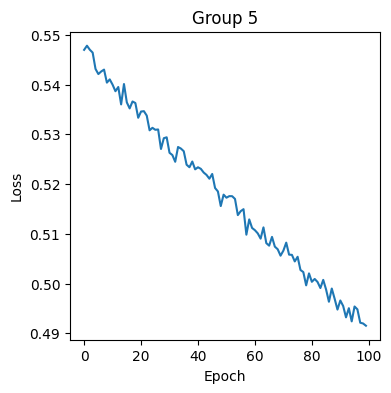

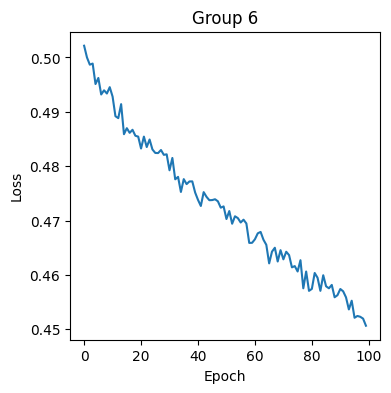

In [61]:
for i, loss_group in enumerate(loss_groups):
    plt.figure(figsize=(4,4))
    plt.plot(range(len(loss_group)), loss_group)
    plt.title(f'Group {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [62]:
import numpy as np
average_f1_score = np.mean(f1_scores)
print(f"Average F1 Score: {average_f1_score}")

Average F1 Score: 0.7116376680497168
